In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

In [3]:
## The following code downloads the blocks file from source
## No longer needed because we set up a data submodule
# import re
# from io import BytesIO
# from urllib.request import urlopen
# from zipfile import ZipFile

# download and unzip blocks manually because of its big size
# zipurl = 'https://live.laborstats.alaska.gov/cen/maps/gis/Blocks2020.zip'
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         zfile.extractall('/tmp/Blocks2020')

In [12]:
# load shapefile from AK's Department of Labor and Workforce Development
# https://live.laborstats.alaska.gov/cen/maps-gis
boroughs = gpd.read_file('../DSSG2023-Heating-Loads-Data/shapefiles/Boroughs2020/')
places = gpd.read_file("../DSSG2023-Heating-Loads-Data/shapefiles/Places2020/") 
census_tracts = gpd.read_file("../DSSG2023-Heating-Loads-Data/shapefiles/Tracts2020/")
block_groups = gpd.read_file("../DSSG2023-Heating-Loads-Data/shapefiles/BlockGroups2020/")
blocks = gpd.read_file("../DSSG2023-Heating-Loads-Data/shapefiles/Blocks2020/")

# make column names lower case
boroughs.columns = map(str.lower, boroughs.columns)
places.columns = map(str.lower, places.columns)
census_tracts.columns = map(str.lower, census_tracts.columns)
block_groups.columns = map(str.lower, block_groups.columns)
blocks.columns = map(str.lower, blocks.columns)

In [4]:
# Number of observations at each level
num_obs = [["boroughs", len(boroughs)],
           ["places", len(places)],
           ["census_tracts", len(census_tracts)],
           ["block_groups", len(block_groups)],
           ["blocks", len(blocks)]]

print(tabulate(num_obs, headers = ['Level of obs', 'N']))

Level of obs        N
--------------  -----
boroughs           30
places            355
census_tracts     177
block_groups    28568
blocks          28568


In [5]:
# average stats at every level 
avg_stats = [["boroughs", len(boroughs), boroughs['totalpop'].mean(), boroughs['houseunits'].mean()],
             ["places", len(places), places['totalpop'].mean(), places['houseunits'].mean()],
             ["census_tracts", len(census_tracts), census_tracts['totalpop'].mean(), census_tracts['houseunits'].mean()],
             ["block_groups", len(block_groups), block_groups['totalpop'].mean(), block_groups['houseunits'].mean()],
             ["blocks", len(blocks), blocks['totalpop'].mean(), blocks['houseunits'].mean()]]

print(tabulate(avg_stats, headers=['Level of obs', 'N', 'Avg. pop', 'Avg. house units'], floatfmt=".0f"))

Level of obs        N    Avg. pop    Avg. house units
--------------  -----  ----------  ------------------
boroughs           30       24446               10873
places            355        2019                 881
census_tracts     177        4143                1843
block_groups    28568          26                  11
blocks          28568          26                  11


Text(0.5, 1.0, 'Borough (n = 30)')

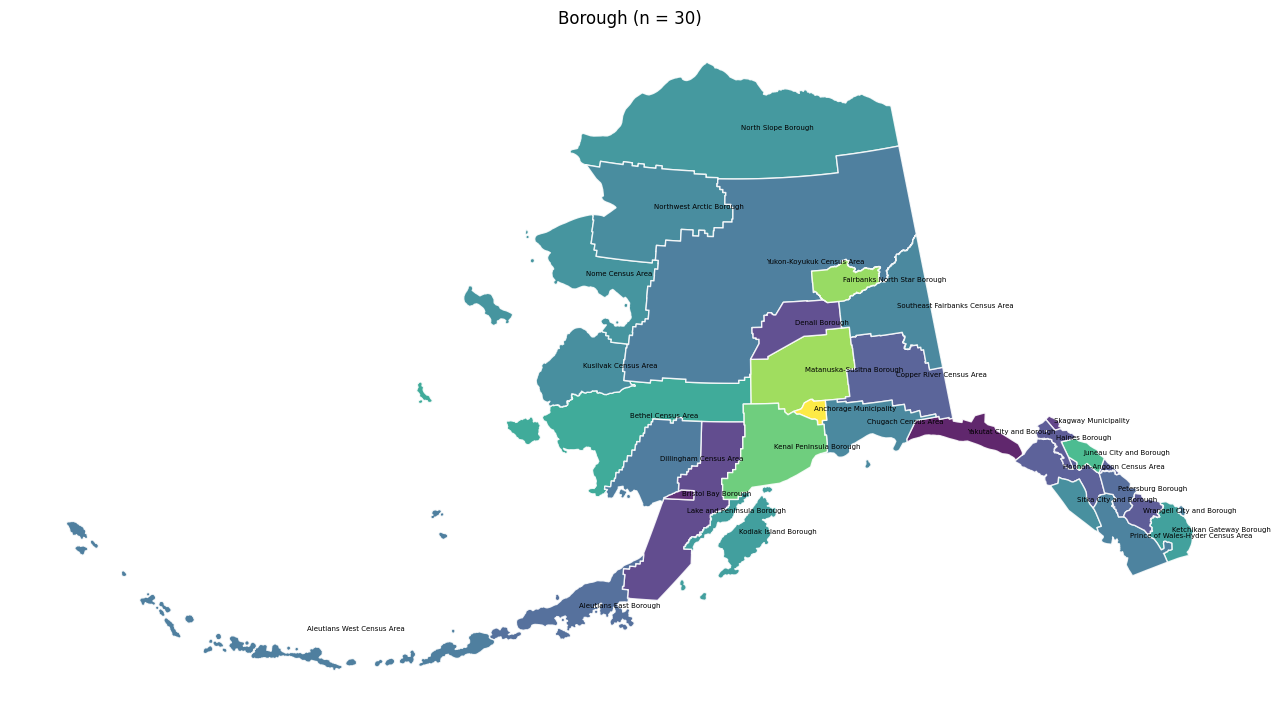

In [7]:
# visualize borough
boroughs['log_pop'] = np.log(boroughs.totalpop)
boroughs['centroid'] = boroughs['geometry'].centroid
boroughs_points = boroughs.copy()
boroughs_points.set_geometry("centroid", inplace = True)


fig, ax = plt.subplots(figsize=(16, 9))
boroughs.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor='white', alpha = 0.85)
ax.set_axis_off()

texts = []
for x, y, label in zip(boroughs_points.geometry.x, boroughs_points.geometry.y, boroughs_points["name"]):
    texts.append(plt.text(x, y, label, fontsize = 5))

plt.title("Borough (n = %s)" % len(boroughs))
#plt.savefig('../Output/Figures/boroughs_vis.png', dpi=1200)

Text(0.5, 1.0, 'Places (n = 355)')

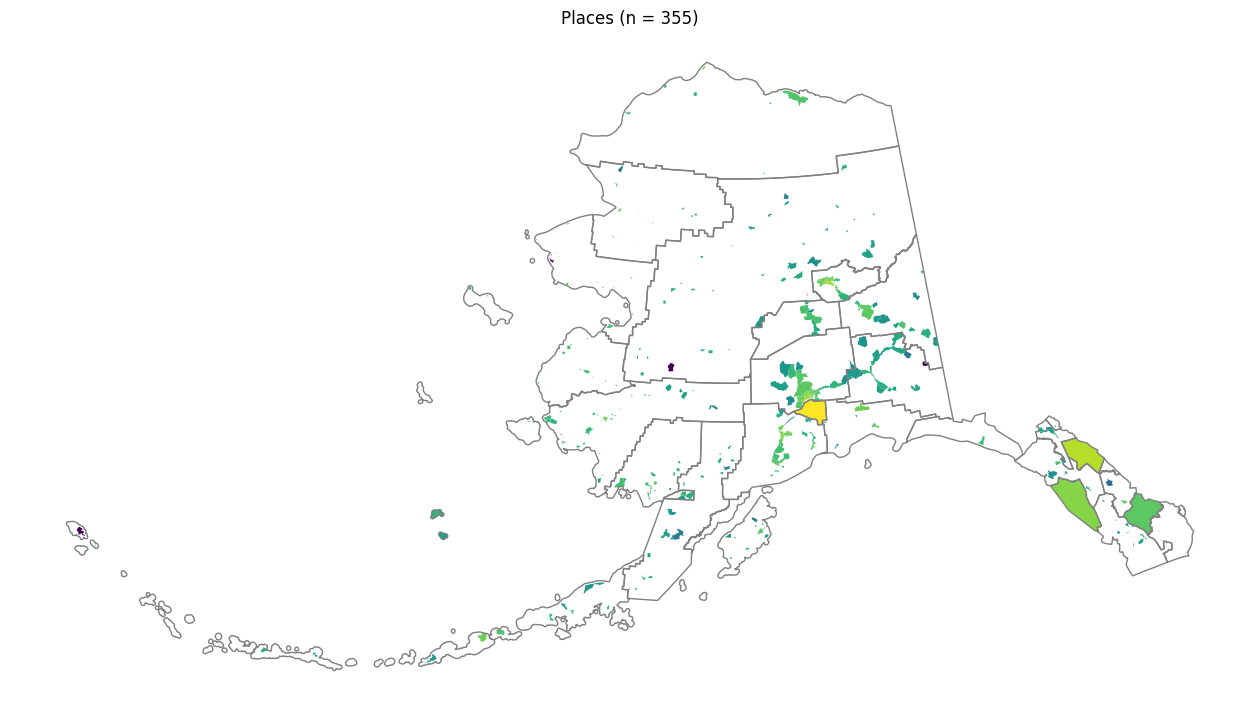

In [8]:
# visualize places
places['log_pop'] = np.log(places.totalpop + 0.001)

fig, ax = plt.subplots(figsize=(16, 9))
places.plot(ax = ax, column="log_pop", figsize=(16, 9))
boroughs.plot(ax = ax, facecolor='none', edgecolor='grey')
ax.set_axis_off()

plt.title("Places (n = %s)" % len(places))
#plt.savefig('../Output/Figures/places_vis.png', dpi=1200)

Text(0.5, 1.0, 'Census tracts (n = 177)')

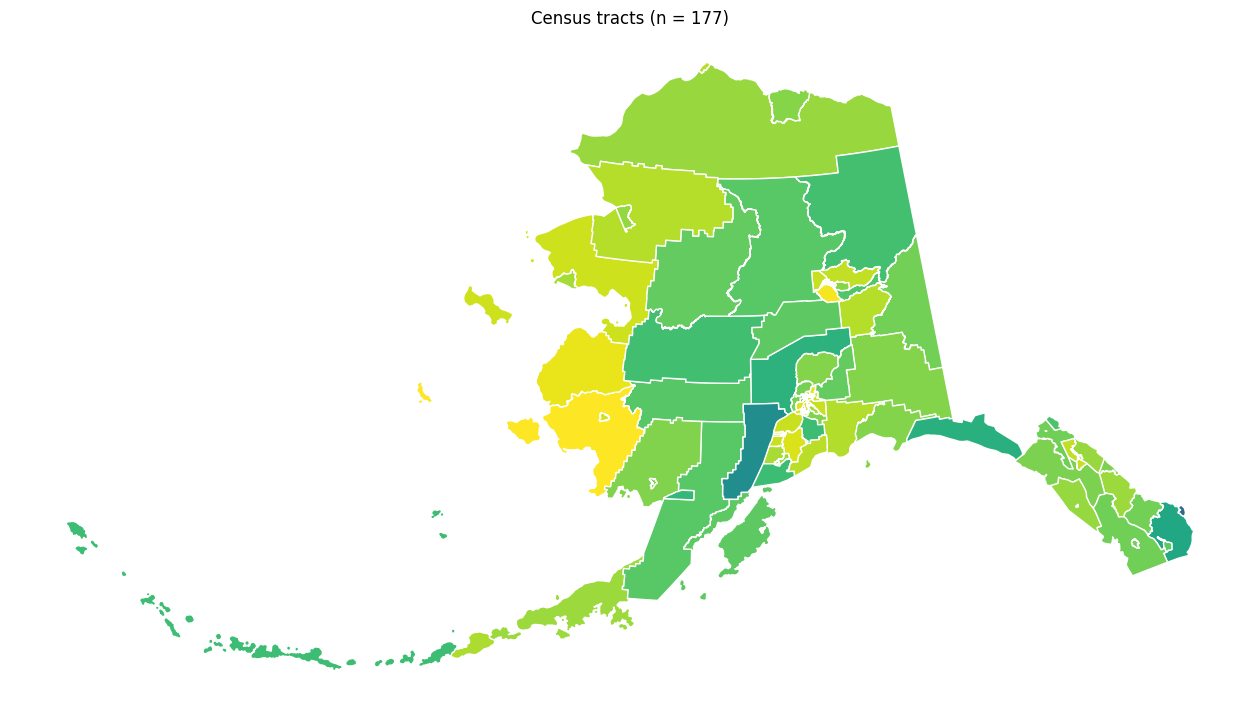

In [9]:
# visualize census tracts
census_tracts['log_pop'] = np.log(census_tracts.totalpop)
fig, ax = plt.subplots(figsize=(16, 9))
census_tracts.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor = 'white')
ax.set_axis_off()
plt.title("Census tracts (n = %s)" % len(census_tracts))
#plt.savefig('../Output/Figures/census_tracts.png', dpi=1200)

Text(0.5, 1.0, 'Block groups (n = 504)')

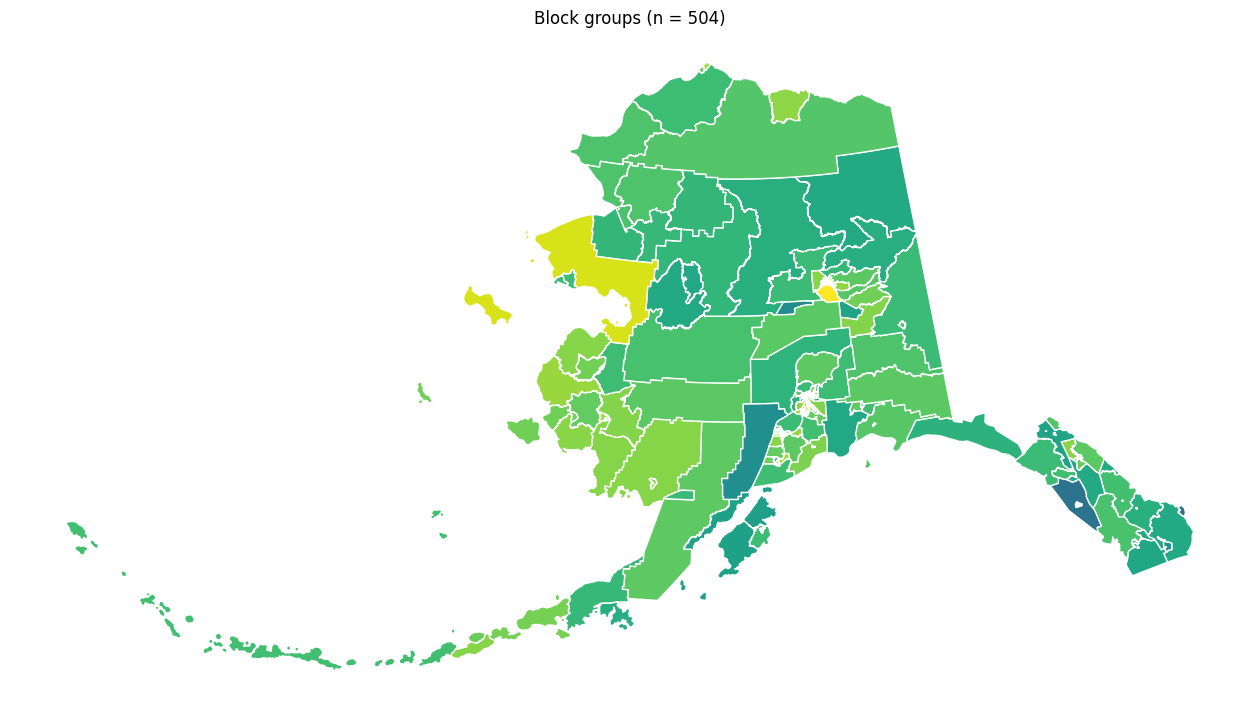

In [13]:
# visualize block_groups
block_groups['log_pop'] = np.log(block_groups.totalpop)
fig, ax = plt.subplots(figsize=(16, 9))
block_groups.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor = 'white')
ax.set_axis_off()
plt.title("Block groups (n = %s)" % len(block_groups))
#plt.savefig('../Output/Figures/block_groups.png', dpi=1200)

Text(0.5, 1.0, 'Block (n = 28568)')

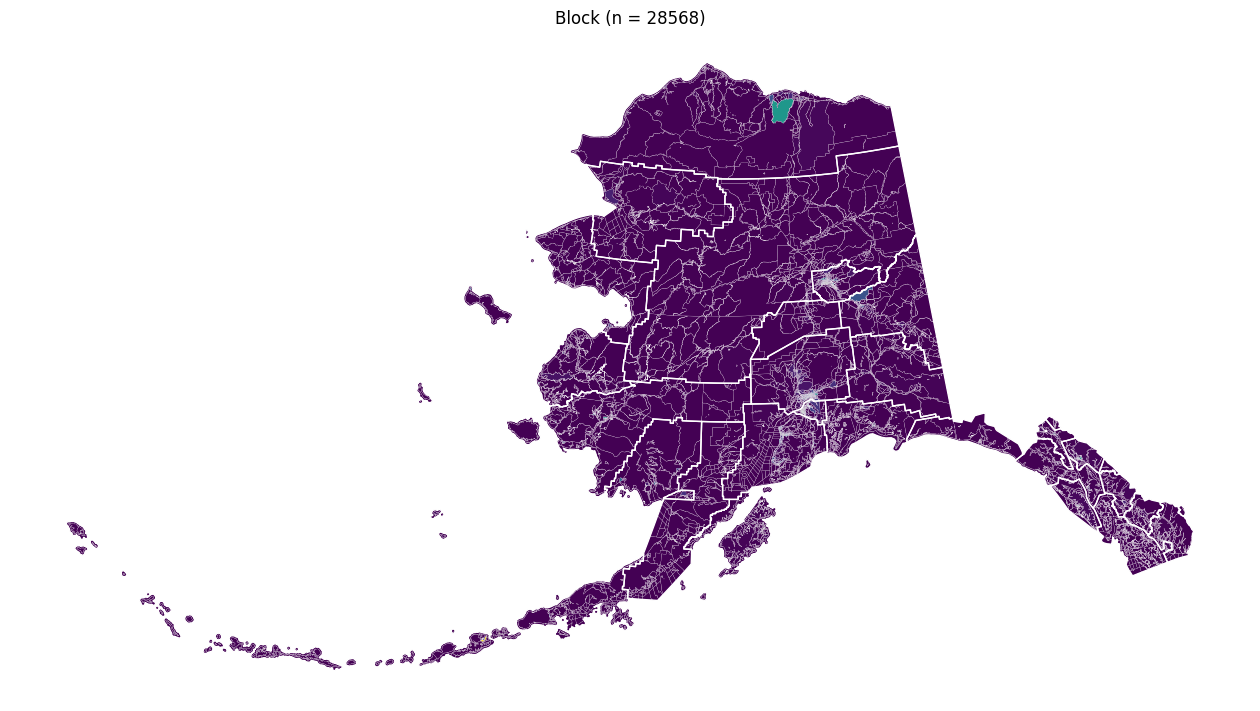

In [11]:
# visualize blocks
blocks['log_pop'] = blocks.totalpop
fig, ax = plt.subplots(figsize=(16, 9))
blocks.plot(ax = ax, column="log_pop", figsize=(16, 9), edgecolor = 'white', lw = 0.1)
boroughs.plot(ax = ax, facecolor='none', edgecolor='white')
ax.set_axis_off()
plt.title("Block (n = %s)" % len(blocks))
#plt.savefig('../Output/Figures/blocks.png', dpi=1200)

In [14]:
## Investigate the difference between Alan's city CSV and Census places 
alan_city = pd.read_csv("../DSSG2023-Heating-Loads-Data/alanMitchellData/city.csv")

In [27]:
alan_census_cities = alan_city['census_city'].str.lower()
ak_places = places['name'].str.lower()

In [28]:
ak_places

0              bethel city
1         chuathbaluk city
2            kwethluk city
3       lower kalskag city
4            mekoryuk city
              ...         
350    excursion inlet cdp
351             haines cdp
352              lutak cdp
353      mosquito lake cdp
354            mud bay cdp
Name: name, Length: 355, dtype: object

In [29]:
alan_census_cities

0      anchorage municipality
1                   adak city
2                 akutan city
3              allakaket city
4                 angoon city
                ...          
272           wainwright city
273            fairbanks city
274                newtok cdp
275             point lay cdp
276              chignik city
Name: census_city, Length: 277, dtype: object

In [30]:
alan_census_cities.isin(ak_places).mean()

0.9891696750902527

### Compare populations at different levels

In [31]:
places_pop = places['totalpop'].sum()

In [32]:
blocks_pop = blocks['totalpop'].sum()

In [33]:
places_pop

716681.0

In [34]:
blocks_pop

733391.0

In [35]:
blocks_pop - places_pop

16710.0

In [36]:
(blocks_pop - places_pop)/blocks_pop * 100

2.2784571940479226

In [37]:
zero_blocks = blocks['totalpop'] == 0
zero_blocks.mean()

0.5881755810697283